In [20]:
%load_ext autoreload
%autoreload 2

from typing import Union

from IPython.display import display
from collections import Counter

import numpy as np

import torch
import torch.optim as optim

from torchvision.transforms import transforms

from models import *

from preprocessing import import_and_preprocess

import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device : {device}")

Using device : cuda


## Import and preprocess data

In [3]:
train_dataloader, valid_dataloader, test_dataloader, label_mapping = import_and_preprocess(
    dataset="marmal88/skin_cancer",
    resize=(256, 256),
    centercrop=(224, 224),
    batch_size=64,
    shuffle=True
)

### Cancer repartition

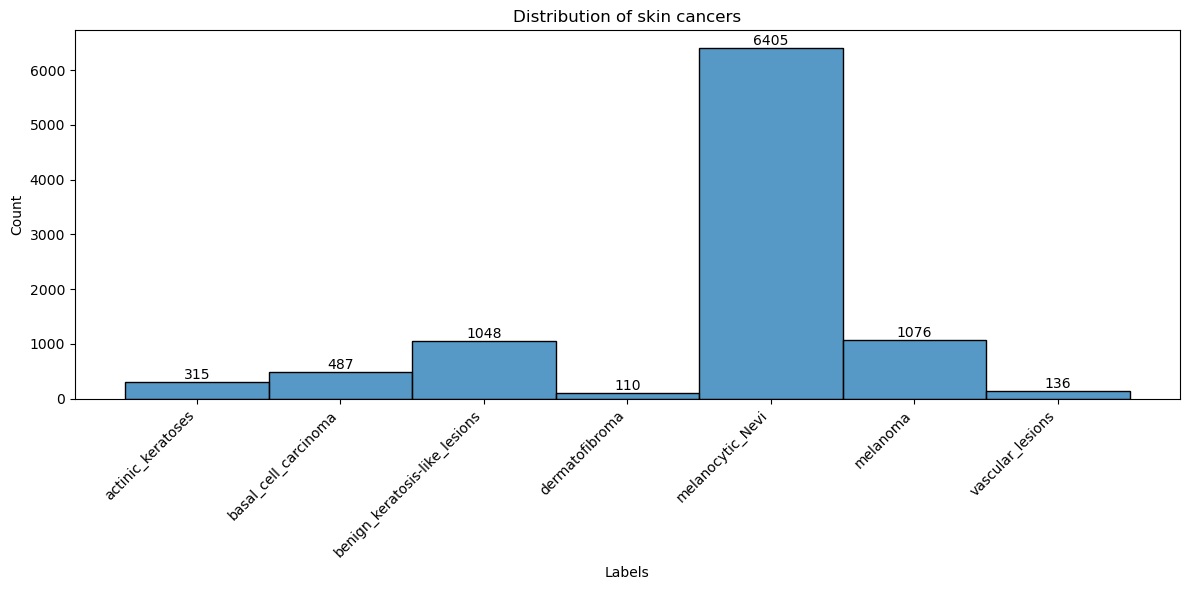

In [4]:
unique_labels = train_dataloader.dataset[:][1].tolist()
label_count = [label_mapping[val] for val in unique_labels]
counts = Counter(label_count)

plt.figure(figsize=(12, 6))

ax = sns.histplot(label_count, bins=len(set(label_count)), discrete=True)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2, height,
                f"{int(height)}", ha="center", va="bottom", fontsize=10)

ax.set_title("Distribution of skin cancers")
ax.set_xlabel("Labels")
plt.xticks(rotation=45, ha="right")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

Randomly select an image and display it with its associated label.

actinic_keratoses


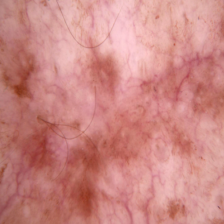

In [5]:
random_idx = np.random.choice([i for i in range(len(train_dataloader))])
img = transforms.ToPILImage()(train_dataloader.dataset[random_idx][0])
img_label = label_mapping[int(train_dataloader.dataset[random_idx][1])]
print(img_label)
display(img)

In [ ]:
# model = SmallNetwork().to(device)
model = ResNet18(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# train the model for n epochs
train_loss_history, val_loss_history = [], []
train_accuracy_history, val_accuracy_history = [], []
n_epochs = 20
for epoch in range(1, n_epochs + 1):
    train_loss_list = []
    train_correct = 0
    model.train() # Set model in training mode (useful for BatchNorm and Dropout)

    for batch_idx, (data, label) in enumerate(train_dataloader):
        data, label = data.to(device), label.to(device)

        # Make predictions and compute loss
        y_pred = model(data)
        loss = criterion(y_pred, label)
        train_loss_list.append(loss)

        # One step optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Retrieve correct predictions and count them
        train_pred = y_pred.argmax(dim=1, keepdim=True)
        train_correct += train_pred.eq(label.view_as(train_pred)).sum().item()

        # Show metrics foreach 10 batch
        if batch_idx % 10 == 0:
            print("Train Epoch {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100 * batch_idx / len(train_dataloader), loss.item()
            ))

    # Average loss and accuracy for the training set
    avg_train_loss = sum(train_loss_list) / len(train_loss_list)
    train_size = len(train_dataloader.dataset)
    train_accuracy = train_correct / train_size * 100
    print("\nTrain set : Average Loss : {}, Accuracy : {}/{} ({:.0f}%)".format(
        avg_train_loss, train_correct, train_size, train_accuracy
    ))

    train_loss_history.append(avg_train_loss)
    train_accuracy_history.append(train_accuracy)

    # Validation part
    val_loss_list = [] 
    val_correct = 0
    model.eval() # Set the model in evaluation mode
    with torch.no_grad():
        for data, label in valid_dataloader:
            data, label = data.to(device), label.to(device)

            # Predictions and loss calculation
            y_pred = model(data)
            val_loss = criterion(y_pred, label)
            val_loss_list.append(val_loss)

            # Count correct predictions
            pred = y_pred.argmax(dim=1, keepdim=True)
            val_correct += pred.eq(label.view_as(pred)).sum().item()

    # Average loss and accuracy for validation set
    avg_val_loss = sum(val_loss_list) / len(val_loss_list)
    val_size = len(valid_dataloader.dataset)
    val_accuracy = val_correct / val_size * 100
    print("\nValidation set : Average Loss: {:.4f}, Accuracy : {}/{} ({:.0f}%)\n".format(
        avg_val_loss, val_correct, val_size, val_accuracy
    ))

    val_loss_history.append(avg_val_loss)
    val_accuracy_history.append(val_accuracy)

In [ ]:
model = ResNet18(num_classes=7).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()

n_epochs = 20

train_loss_history, train_accuracy_history = [], []
val_loss_history, val_accuracy_history = [], []

for epoch in range(1, n_epochs + 1):
    epoch_train_loss, epoch_train_accuracy = train_model(
        model=model,
        device=device,
        train_loader=train_dataloader,
        loss_function=loss_function,
        optimizer=optimizer,
        epoch=epoch,
        save=True,
        verbose=True
    )

    train_loss_history.append(epoch_train_loss)
    train_accuracy_history.append(epoch_train_accuracy)

    epoch_val_loss, epoch_val_accuracy = validate_model(
        model=model,
        device=device,
        valid_loader=valid_dataloader,
        loss_function=loss_function,
        save=True,
        verbose=True
    )

    val_loss_history.append(epoch_val_loss)
    val_accuracy_history.append(epoch_val_accuracy)

Train Epoch 1 [0/9577 (0%)]	Loss: 1.916638
Train Epoch 1 [640/9577 (0%)]	Loss: 0.926408
Train Epoch 1 [1280/9577 (0%)]	Loss: 1.138054
Train Epoch 1 [1920/9577 (0%)]	Loss: 1.026137
Train Epoch 1 [2560/9577 (0%)]	Loss: 0.548471
Train Epoch 1 [3200/9577 (1%)]	Loss: 0.995869
Train Epoch 1 [3840/9577 (1%)]	Loss: 0.984703
Train Epoch 1 [4480/9577 (1%)]	Loss: 0.817206
Train Epoch 1 [5120/9577 (1%)]	Loss: 0.772696
Train Epoch 1 [5760/9577 (1%)]	Loss: 0.840616
Train Epoch 1 [6400/9577 (1%)]	Loss: 0.952040
Train Epoch 1 [7040/9577 (1%)]	Loss: 0.829778
Train Epoch 1 [7680/9577 (1%)]	Loss: 0.706986
Train Epoch 1 [8320/9577 (1%)]	Loss: 0.741064
Train Epoch 1 [8960/9577 (1%)]	Loss: 0.623857
Train set : Average loss 0.8367, Accuracy : 6618/9577 (69%)

Validation set : Average Loss: 0.7633, Accuracy : 1797/2492 (72%)

Train Epoch 2 [0/9577 (0%)]	Loss: 0.581658
Train Epoch 2 [640/9577 (0%)]	Loss: 0.879190
Train Epoch 2 [1280/9577 (0%)]	Loss: 0.631780
Train Epoch 2 [1920/9577 (0%)]	Loss: 0.550410
Train 

In [84]:
test_correct = 0
with torch.no_grad():
    for test_data, test_label in test_dataloader:
        y_pred_test = model(test_data.to(device)).argmax(dim=1, keepdim=True)
        test_correct += y_pred_test.eq(test_label.to(device).view_as(y_pred_test)).sum().item()

print("Test accuracy : {}/{} ({:.0f}%)".format(
    test_correct, len(test_dataloader.dataset), 
    test_correct / len(test_dataloader.dataset) * 100
))

Test accuracy : 1195/1285 (93%)


Predict on a random chosen image from the test dataset and see the predictions with asociated probabilities

Predicted : 4, Actual : 4


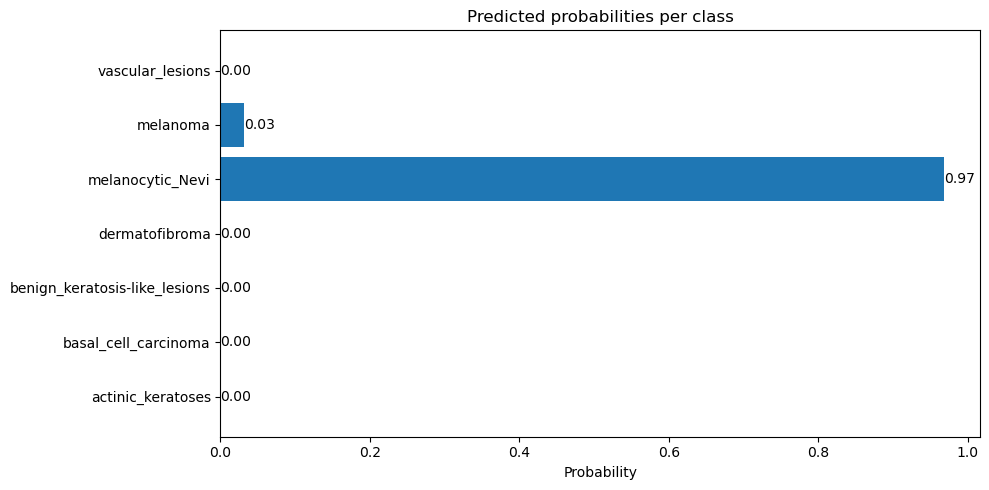

In [89]:
idx = np.random.choice(len(test_dataloader.dataset))
example = test_dataloader.dataset[idx][0].unsqueeze(0).to(device)
example_label = test_dataloader.dataset[idx][1].unsqueeze(0).to(device)
with torch.no_grad():
    output = model(example)
    print(f"Predicted : {output.argmax(1).item()}, Actual : {example_label.item()}")

probs = nn.functional.softmax(output[0], dim=0).tolist()

fig, ax_h = plt.subplots(figsize=(10, 5))
bars = ax_h.barh(list(label_mapping.values()), probs)

for bar in bars:
    width = bar.get_width()
    ax_h.text(width, bar.get_y() + bar.get_height() / 2,
            f"{width:.2f}", va="center")

ax_h.set_title("Predicted probabilities per class")
ax_h.set_xlabel("Probability")
plt.tight_layout()
plt.show()